Professional Prompt for PINN-Based Discharge Prediction Using PyTorch (RTX 6000 GPU)
Objective:
We aim to develop a Physics-Informed Neural Network (PINN) using PyTorch to predict discharge (rg_qms) at hydrometric stations based on rainfall, spatial terrain data, and temporal evolution. The model will be trained on historical data from multiple years, tested on available years, and run efficiently on an NVIDIA RTX 6000 GPU using batch processing and real-time monitoring.

Dataset Description & File Paths:
The dataset is structured as merged hydrological data containing spatiotemporal features. The data is stored in the following directory:
📂 Path:
/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/

📄 File Names:

Merged_North_Dead_Sea_2012.csv
Merged_North_Dead_Sea_2013.csv
Merged_North_Dead_Sea_2014.csv
Merged_North_Dead_Sea_2015.csv
Merged_North_Dead_Sea_2016.csv
Merged_North_Dead_Sea_2018.csv
Merged_North_Dead_Sea_2019.csv
Merged_North_Dead_Sea_2020.csv
🔹 Columns Available:

Time Variables:

time (Datetime) – Timestamp of the observation.
Spatial Features:

longitude, latitude (Float) – Spatial coordinates of each observation.
elevation (Float) – Elevation of each grid point.
slope_calculated (Float) – Terrain slope, useful for estimating flow direction.
Hydrometeorological Inputs:

rainrate (Float) – Rainfall intensity at each location.
rg_qms (Float) – Discharge at specific hydrometric stations (our target variable).
Data Gaps:

rg_qms is only available for three specific station locations per time step.
Other locations contain NaN values.
Task for the PINN Model:
The PINN will be trained to:

Learn the relationship between past rainfall and discharge using historical years as training data.
Enforce physics constraints using governing equations like the kinematic wave equation.
Predict rg_qms at future timestamps based on rainfall inputs and spatial information.
Generalize across different years, testing model robustness.
Model Architecture & Training Strategy (PyTorch PINN)
1️⃣ Input Features:
Time-dependent inputs: rainrate, time, historical discharge values (if available).
Spatial inputs: longitude, latitude, elevation, slope_calculated.
2️⃣ PINN Constraints (Loss Functions)
Data Loss (L_data): Mean Squared Error (MSE) on discharge predictions.
Physics Residual Loss (L_physics):
Continuity Equation: Ensures smooth discharge variations over space and time.
Momentum Conservation: Captures flow behavior based on terrain slope.
Final Loss Function:
𝐿
=
𝐿
data
+
𝜆
𝐿
physics
L=L 
data
​
 +λL 
physics
​
 
where λ is a weighting parameter to balance data and physics loss.
3️⃣ Model Architecture (PyTorch)
Fully Connected Neural Network (FCNN)
Layers: 4-6 layers with Sine Activation (SinAct) for handling physics constraints.
Neurons: 128-256 per layer.
Batch Normalization: Improves training stability.
Dropout Layers: Reduces overfitting.
4️⃣ Training & GPU Optimization
Hardware: NVIDIA RTX 6000 GPU with CUDA acceleration.
Batch Processing: Uses mini-batches of 256 or 512 samples for efficient memory usage.
Optimization Strategy:
Adam optimizer for fast convergence.
L-BFGS optimizer for final refinement.
Gradient Clipping: Prevents instability in training.
Training & Validation Plan
Train on: 2012, 2013, 2014, 2015.
Test on: 2016, 2018, 2019, 2020.
Evaluation Metrics:
Root Mean Squared Error (RMSE).
Nash-Sutcliffe Efficiency (NSE).
R² Score to measure prediction accuracy.
Tracking Model Progress
✅ Live Loss Monitoring: Logs loss function values (data loss + physics loss) during training.
✅ Batch-wise Validation: Computes validation loss every N batches for real-time progress tracking.
✅ TensorBoard Integration: If needed, to visualize training curves.
✅ Real-Time Model Checkpoints: Saves the best model based on validation loss.

Deliverables
A fully trained PINN model capable of predicting discharge (rg_qms).
Validation plots comparing model predictions vs. observed discharge.
Physics-based insights into water flow behavior.
Generalization analysis across different years.
Final Request
Implement this using PyTorch + CUDA, utilizing batch-based training on the RTX 6000 GPU. Ensure real-time progress tracking and visualization of predictions vs. observed data.

In [1]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# 1. DATA LOADING & PREPROCESSING
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012', '2013', '2014', '2015']
TEST_YEARS  = ['2016', '2018', '2019', '2020']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Specify data types to reduce memory usage.
# Adjust the types based on your actual data.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
    # You can add other columns if needed.
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            # Use the dtypes dictionary and parse dates
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# Uncomment below for debugging with a smaller subset.
# log_message("Using a small subset of data for debugging.")
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

time_col     = 'time'
spatial_cols = ['longitude', 'latitude', 'elevation', 'slope_calculated']
hydro_cols   = ['rainrate']
target_col   = 'rg_qms'

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0 + df['time'].dt.second / 3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

feature_cols = ['time_sin', 'time_cos'] + spatial_cols + hydro_cols

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. CUSTOM DATASET & DATALOADER
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets  = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

# Reduced batch size to help with memory issues
BATCH_SIZE = 64

train_dataset = HydrologyDataset(train_df, feature_cols, target_col)
test_dataset  = HydrologyDataset(test_df, feature_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. MODEL DEFINITION: PINN ARCHITECTURE
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. LOSS FUNCTIONS & PHYSICS CONSTRAINTS
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

def physics_loss(model, x, pred):
    longitude_idx = 2  # Adjust if necessary
    x.requires_grad_(True)
    pred = model(x)
    grad = torch.autograd.grad(outputs=pred, inputs=x, grad_outputs=torch.ones_like(pred),
                               create_graph=True, retain_graph=True)[0]
    d_pred_d_long = grad[:, longitude_idx]
    physics_residual = torch.mean(d_pred_d_long ** 2)
    return physics_residual

lambda_phys = 1.0

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()  # maintain tensor type
    phys_loss_val = physics_loss(model, x, y_pred)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. TRAINING SETUP: OPTIMIZERS, SCHEDULERS & LOGGING
# =============================
log_message("Setting up optimizer and logging...")

optimizer = optim.Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_val_loss = float('inf')
log_message("Training setup complete.")

# =============================
# 6. TRAINING LOOP WITH RUNTIME MONITORING
# =============================
log_message("Starting training loop...")
start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(n_epochs):
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)  # Ensure shape (B, 1)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Monitor GPU memory usage (if available)
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# 7. OPTIONAL L-BFGS REFINEMENT
# =============================
# Uncomment and modify if L-BFGS refinement is desired.
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):  # a few epochs for refinement
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# 8. SAVE FINAL MODEL & CLOSE LOGGING
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


2025-02-18 09:34:14.889527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[2025-02-18 09:34:17] Starting data loading...
[2025-02-18 09:34:17] Loading training data...
[2025-02-18 09:34:17] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-18 09:35:39] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-18 09:36:58] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2014.csv
[2025-02-18 09:38:19] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2015.csv
[2025-02-18 09:39:37] Loading testing data...
[2025-02-18 09:39:37] Loading file: /media/data-ssd/PINN/DATA/model data after proccessi

KeyboardInterrupt: 

In [ ]:
the code above workes. the next cell is improved code that take advange the gpu:

In [ ]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# GPU Optimization Settings
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Use cuDNN auto-tuner to find best algorithm
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. DATA LOADING & PREPROCESSING
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012', '2013', '2014', '2015']
TEST_YEARS  = ['2016', '2018', '2019', '2020']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Specify data types to reduce memory usage.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
    # Add other columns if necessary.
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# Optionally, for debugging, you can use a smaller subset.
# log_message("Using a small subset of data for debugging.")
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

time_col     = 'time'
spatial_cols = ['longitude', 'latitude', 'elevation', 'slope_calculated']
hydro_cols   = ['rainrate']
target_col   = 'rg_qms'

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0 + df['time'].dt.second / 3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

feature_cols = ['time_sin', 'time_cos'] + spatial_cols + hydro_cols

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. CUSTOM DATASET & DATALOADER
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets  = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

# Use a reduced batch size to help with memory issues.
BATCH_SIZE = 64

# If using GPU, set pin_memory=True for faster host-to-device transfers.
train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. MODEL DEFINITION: PINN ARCHITECTURE
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. LOSS FUNCTIONS & PHYSICS CONSTRAINTS
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

def physics_loss(model, x, pred):
    longitude_idx = 2  # Adjust if necessary
    x.requires_grad_(True)
    pred = model(x)
    grad = torch.autograd.grad(outputs=pred, inputs=x, grad_outputs=torch.ones_like(pred),
                               create_graph=True, retain_graph=True)[0]
    d_pred_d_long = grad[:, longitude_idx]
    physics_residual = torch.mean(d_pred_d_long ** 2)
    return physics_residual

lambda_phys = 1.0

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()  # maintain tensor type
    phys_loss_val = physics_loss(model, x, y_pred)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. TRAINING SETUP: OPTIMIZER, CHECKPOINT RESUME & LOGGING
# =============================
log_message("Setting up optimizer and logging...")

optimizer = optim.Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Resume training if a checkpoint exists.
resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. TRAINING LOOP WITH RUNTIME MONITORING, CHECKPOINT SAVING & EPOCH TIME ESTIMATION
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)  # Ensure shape (B, 1)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improved.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Save latest checkpoint for resume.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # Monitor GPU memory usage (if available)
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# 7. OPTIONAL L-BFGS REFINEMENT (COMMENTED OUT)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):  # a few epochs for refinement
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# 8. SAVE FINAL MODEL & CLOSE LOGGING
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


[2025-02-18 10:24:17] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-18 10:24:17] Starting data loading...
[2025-02-18 10:24:17] Loading training data...
[2025-02-18 10:24:17] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-18 10:25:37] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-18 10:26:57] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2014.csv
[2025-02-18 10:28:16] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2015.csv
[2025-02-18 10:29:36] Loading testing data...
[2025-02-18

In [ ]:
the last one is dies - also I figure out that the loss is without kynematic wave. so here is an update one:

In [1]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# פונקציית רישום הודעות (Logging)
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# הגדרות לאופטימיזציה של GPU
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # מאפשר אוטוטיונינג של cuDNN לביצועים מיטביים
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. טעינת הנתונים והכנה
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012', '2013', '2014', '2015']
TEST_YEARS  = ['2016', '2018', '2019', '2020']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# כדי לחסוך בזיכרון, נגדיר סוגי נתונים
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
    # אפשר להוסיף עמודות נוספות לפי הצורך.
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# אפשר להשתמש בחלק קטן מהנתונים לצורך דיבוג (לא חובה)
# log_message("Using a small subset of data for debugging.")
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

# עיבוד תכונת הזמן:
# מחשבים את השעה כערך עשרוני ושומרים אותה בעמודה "hour"
time_col = 'time'
def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0 + df['time'].dt.second / 3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

# כעת נבנה רשימת תכונות שמכילה גם את "hour" למטרת חישוב נגזרות בזמן
feature_cols = ['hour', 'time_sin', 'time_cos'] + ['longitude', 'latitude', 'elevation', 'slope_calculated'] + ['rainrate']

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_col = 'rg_qms'
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. יצירת Dataset וטוען נתונים (DataLoader)
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

BATCH_SIZE = 64

train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. הגדרת המודל (PINN ARCHITECTURE)
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. הגדרת פונקציות אובדן ואילוצים פיזיקליים
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

# כאן אנו מגדירים את "אובדן הגל הקינטמטי":
# אנו מחשבים את הנגזרת של q (הניבוי) לפי זמן (העמודה 'hour') ופי x (העמודה 'longitude')
# ומנסים לאכוף את המשוואה: dq/dt + c * dq/dx = 0, כאשר c קבוע (נניח c=1)
def physics_loss(model, x):
    # ודא ש-x מאפשר חישוב נגזרות
    x.requires_grad_(True)
    q = model(x)
    # חשב את הנגזרות של q ביחס לכל תכונה
    grad = torch.autograd.grad(outputs=q, inputs=x, grad_outputs=torch.ones_like(q),
                               create_graph=True, retain_graph=True)[0]
    # בהנחה שהעמודה 0 היא "hour" (זמן) והעמודה 3 היא "longitude"
    dQ_dt = grad[:, 0]  # נגזרת לפי זמן
    dQ_dx = grad[:, 3]  # נגזרת לפי קו אורך
    c = 1.0  # מהירות גל (קבוע)
    residual = torch.mean((dQ_dt + c * dQ_dx)**2)
    return residual

lambda_phys = 1.0  # משקל לאובדן הפיזיקלי

def combined_loss(model, x, y_true):
    # מחשב את ניבוי המודל q
    y_pred = model(x)
    # מחשב את אובדן הנתונים (MSE) רק עבור הדוגמאות בהן יש ערך תקף
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()  # לשמירת טיפוס הטנזור
    # מחשב את אובדן הגל הקינטמטי
    phys_loss_val = physics_loss(model, x)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. הגדרת האופטימייזר, שמירת התקדמות (Checkpoint) ורישום
# =============================
log_message("Setting up optimizer and logging...")

optimizer = optim.Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# בדיקה האם קיימת נקודת שמירה להמשך אימון
resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. לולאת האימון עם מדידת זמן עידן ושמירת נקודות
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)  # מבטיח שהצורה תהיה (B, 1)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # שלב בדיקת ביצועים (Validation)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # שמירת נקודת שמירה אם האובדן בבדיקה השתפר
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # שמירת נקודת שמירה עדכנית (latest) לצורך המשך אימון במידה והאימון יופסק
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # ניטור שימוש בזיכרון GPU (אם זמין)
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# 7. אפשרות ל-L-BFGS (מושבת)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):  # כמה עידנים לליטוש
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# 8. שמירת המודל הסופי וסגירת רישום
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


2025-02-18 10:41:19.589834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[2025-02-18 10:41:21] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-18 10:41:21] Starting data loading...
[2025-02-18 10:41:21] Loading training data...
[2025-02-18 10:41:21] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-18 10:42:43] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-18 10:44:02] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2014.csv
[2025-02-18 10:45:21] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2015.csv
[2025-02-18 10:46:39] Loading testing data...
[2025-02-18

Loaded model from checkpoint.


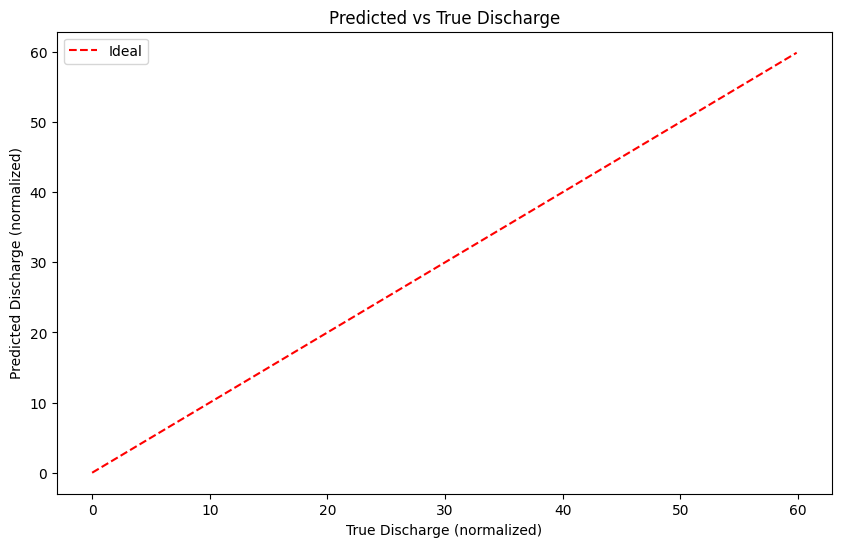

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Define the Sine activation and the model architecture ---
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        # Output layer
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# --- Set up the device and load the saved model checkpoint ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# In training, we used 8 features: ['hour', 'time_sin', 'time_cos', 'longitude', 'latitude', 'elevation', 'slope_calculated', 'rainrate']
model = PINNModel(in_features=8, out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
checkpoint_path = "./checkpoints/pinn_final.pth"  # adjust if needed
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
print("Loaded model from checkpoint.")

# --- Load and preprocess test data ---
# For example, we load one of your test CSV files.
# Ensure the CSV file contains the columns: time, longitude, latitude, elevation, slope_calculated, rainrate, and rg_qms.
test_file = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2020.csv"
test_df = pd.read_csv(test_file, parse_dates=['time'])

# Preprocess the time features as done in training:
test_df["hour"] = test_df["time"].dt.hour + test_df["time"].dt.minute/60.0 + test_df["time"].dt.second/3600.0
test_df["time_sin"] = np.sin(2 * np.pi * test_df["hour"] / 24.0)
test_df["time_cos"] = np.cos(2 * np.pi * test_df["hour"] / 24.0)

# Define feature columns (must match the training order)
feature_cols = ["hour", "time_sin", "time_cos", "longitude", "latitude", "elevation", "slope_calculated", "rainrate"]

# For visualization, we only consider rows where we have a valid target value:
test_df_valid = test_df[test_df["rg_qms"].notna()].copy()

# Extract features and target:
X_test = test_df_valid[feature_cols].values.astype(np.float32)
y_true = test_df_valid["rg_qms"].values.astype(np.float32)

# Convert features to a torch tensor:
X_test_tensor = torch.tensor(X_test).to(device)

# --- Use the model to predict ---
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.cpu().numpy().flatten()

# --- Visualization: Plot predicted vs. true discharge ---
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("True Discharge (normalized)")
plt.ylabel("Predicted Discharge (normalized)")
plt.title("Predicted vs True Discharge")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal")
plt.legend()
plt.show()


Loaded model from checkpoint.


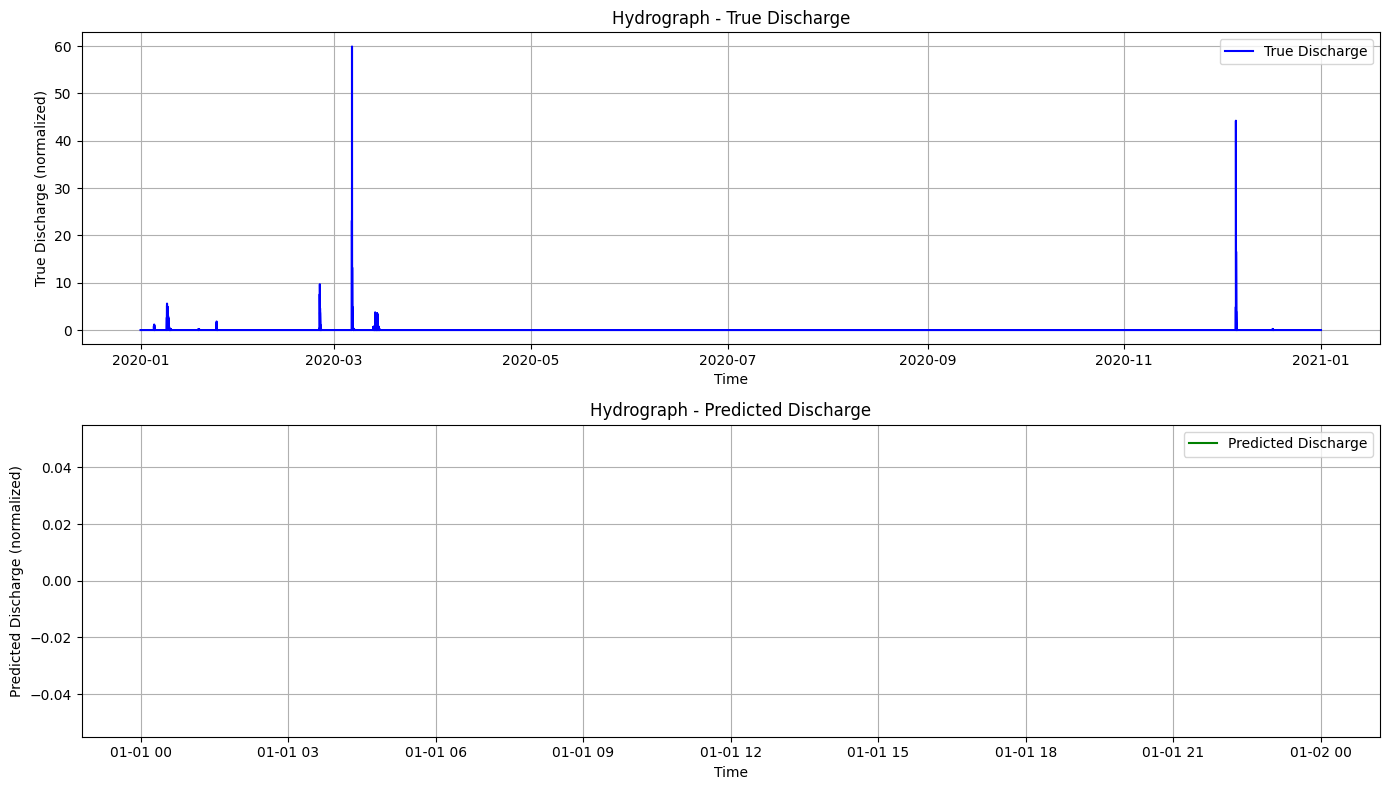

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- Define the Sine activation and the model architecture ---
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        # Output layer
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# --- Set up the device and load the saved model checkpoint ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# We used 8 features during training: ['hour', 'time_sin', 'time_cos', 'longitude', 'latitude', 'elevation', 'slope_calculated', 'rainrate']
model = PINNModel(in_features=8, out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
checkpoint_path = "./checkpoints/pinn_final.pth"  # Adjust path if needed
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
print("Loaded model from checkpoint.")

# --- Load and preprocess test data ---
# Change this to one of your test CSV files.
test_file = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2020.csv"
test_df = pd.read_csv(test_file, parse_dates=['time'])

# Preprocess the time features as done in training
test_df["hour"] = test_df["time"].dt.hour + test_df["time"].dt.minute/60.0 + test_df["time"].dt.second/3600.0
test_df["time_sin"] = np.sin(2 * np.pi * test_df["hour"] / 24.0)
test_df["time_cos"] = np.cos(2 * np.pi * test_df["hour"] / 24.0)

# Define feature columns in the same order as used during training.
feature_cols = ["hour", "time_sin", "time_cos", "longitude", "latitude", "elevation", "slope_calculated", "rainrate"]

# For visualization, we consider only rows where the target 'rg_qms' is valid.
test_df_valid = test_df[test_df["rg_qms"].notna()].copy()

# Extract the features and the true target values
X_test = test_df_valid[feature_cols].values.astype(np.float32)
y_true = test_df_valid["rg_qms"].values.astype(np.float32)

# Convert features to a torch tensor.
X_test_tensor = torch.tensor(X_test).to(device)

# --- Compute predictions ---
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.cpu().numpy().flatten()

# --- Create hydrograph plots on two separate subplots ---
# Convert time column to datetime for plotting.
times = pd.to_datetime(test_df_valid["time"])

plt.figure(figsize=(14, 8))

# Subplot 1: True discharge vs. Time
plt.subplot(2, 1, 1)
plt.plot(times, y_true, label="True Discharge", color="blue")
plt.xlabel("Time")
plt.ylabel("True Discharge (normalized)")
plt.title("Hydrograph - True Discharge")
plt.legend()
plt.grid(True)

# Subplot 2: Predicted discharge vs. Time
plt.subplot(2, 1, 2)
plt.plot(times, y_pred, label="Predicted Discharge", color="green")
plt.xlabel("Time")
plt.ylabel("Predicted Discharge (normalized)")
plt.title("Hydrograph - Predicted Discharge")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
print("Shape of X_test_tensor:", X_test_tensor.shape)
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
print("Shape of y_pred_tensor:", y_pred_tensor.shape)
print("First 10 predictions:", y_pred_tensor[:10])

Shape of X_test_tensor: torch.Size([118368, 8])
Shape of y_pred_tensor: torch.Size([118368, 1])
First 10 predictions: tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0')


In [6]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# GPU Optimization Settings
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. Data Loading & Preprocessing (Train on 2012, Test on 2013)
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012']
TEST_YEARS  = ['2013']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Define data types to reduce memory usage.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data (2012)...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data (2013)...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# (Optional: for debugging, use a smaller subset)
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute/60.0 + df['time'].dt.second/3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

# Build feature columns – note we include 'hour' for gradient computation
feature_cols = ['hour', 'time_sin', 'time_cos', 'longitude', 'latitude', 'elevation', 'slope_calculated', 'rainrate']

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_col = 'rg_qms'
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. Custom Dataset & DataLoader
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

BATCH_SIZE = 64

train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. Model Definition (PINN Architecture)
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. Loss Functions & Physics Constraints
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

# Physics Loss: Enforcing the kinematic wave equation: d(q)/dt + c*d(q)/dx = 0 (with c = 1)
def physics_loss(model, x):
    # Ensure x is a fresh leaf tensor that requires gradients.
    x = x.clone().detach().requires_grad_(True)
    q = model(x)
    grad = torch.autograd.grad(outputs=q, inputs=x, grad_outputs=torch.ones_like(q),
                               create_graph=True, retain_graph=True)[0]
    # Assume column 0 is "hour" (time) and column 3 is "longitude"
    dQ_dt = grad[:, 0]
    dQ_dx = grad[:, 3]
    c = 1.0  # wave speed constant
    residual = torch.mean((dQ_dt + c * dQ_dx) ** 2)
    return residual

lambda_phys = 0.1  # Lower the physics loss weight for stability

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()  # preserve tensor type
    phys_loss_val = physics_loss(model, x)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. Optimizer, Checkpointing, and Logging Setup
# =============================
log_message("Setting up optimizer and logging...")

# Lower learning rate for stability
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Resume checkpoint if available
resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. Training Loop with Epoch Timing, Checkpoint Saving & Gradient Norm Logging
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()

            # Log gradient norms for the first few batches for diagnosis
            if batch_idx < 3:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                log_message(f"Batch {batch_idx}: Gradient norm = {total_norm:.4f}")

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improves.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Save the latest checkpoint for resume purposes.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # Monitor GPU memory usage if available.
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# Optional L-BFGS Refinement (Disabled)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# Final Model Saving and Closing Logging
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


[2025-02-19 07:02:48] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-19 07:02:48] Starting data loading...
[2025-02-19 07:02:48] Loading training data (2012)...
[2025-02-19 07:02:48] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-19 07:04:09] Loading testing data (2013)...
[2025-02-19 07:04:09] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-19 07:05:26] Data loading complete.
[2025-02-19 07:05:26] Starting time feature encoding...
[2025-02-19 07:05:26] Encoding training data time features...
[2025-02-19 07:05:28] Encoding testing data time features...
[2025-02-19 07:05:31] Starting feature scaling...
[2025-02-19 07:05:37] Feature scaling complete.
[2025-02-19 07:05:37] Scaling target values for valid measure

KeyboardInterrupt: 

In [7]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# GPU Optimization Settings
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Enables cuDNN auto-tuner for optimal performance
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. Data Loading & Preprocessing (Train on 2012, Test on 2013)
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012']
TEST_YEARS  = ['2013']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Define data types to reduce memory usage.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data (2012)...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data (2013)...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# (Optional: for debugging, you can use a smaller subset)
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute/60.0 + df['time'].dt.second/3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

# Build feature columns – note we include 'hour' for gradient computation.
feature_cols = ['hour', 'time_sin', 'time_cos'] + ['longitude', 'latitude', 'elevation', 'slope_calculated'] + ['rainrate']

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_col = 'rg_qms'
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. Custom Dataset & DataLoader
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

BATCH_SIZE = 64

train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. Model Definition (PINN Architecture)
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. Loss Functions & Physics Constraints
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

# Physics Loss: Enforce the kinematic wave equation: dq/dt + c*dq/dx = 0, where c=1.
def physics_loss(model, x):
    # Create a fresh copy of x that requires gradients
    x = x.clone().detach().requires_grad_(True)
    q = model(x)
    grad = torch.autograd.grad(outputs=q, inputs=x, grad_outputs=torch.ones_like(q),
                               create_graph=True, retain_graph=True)[0]
    # Assume: column 0 = 'hour' (time), column 3 = 'longitude'
    dQ_dt = grad[:, 0]
    dQ_dx = grad[:, 3]
    c = 1.0
    residual = torch.mean((dQ_dt + c * dQ_dx) ** 2)
    return residual

# Temporarily disable physics loss for stability by setting its weight to 0.
lambda_phys = 0.0

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()
    phys_loss_val = physics_loss(model, x)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. Optimizer, Checkpointing, and Logging Setup
# =============================
log_message("Setting up optimizer and logging...")

# Lower the learning rate for stability.
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. Training Loop with Epoch Timing, Checkpoint Saving & Gradient Norm Logging
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            
            # Log gradient norms for first few batches
            if batch_idx < 3:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                log_message(f"Batch {batch_idx}: Gradient norm = {total_norm:.4f}")
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improves.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Save the latest checkpoint for resume purposes.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # Monitor GPU memory usage if available.
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# Optional L-BFGS Refinement (Disabled)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# Final Model Saving and Logging Close
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


[2025-02-19 07:13:28] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-19 07:13:28] Starting data loading...
[2025-02-19 07:13:28] Loading training data (2012)...
[2025-02-19 07:13:28] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-19 07:14:42] Loading testing data (2013)...
[2025-02-19 07:14:42] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-19 07:16:00] Data loading complete.
[2025-02-19 07:16:00] Starting time feature encoding...
[2025-02-19 07:16:00] Encoding training data time features...
[2025-02-19 07:16:02] Encoding testing data time features...
[2025-02-19 07:16:05] Starting feature scaling...
[2025-02-19 07:16:11] Feature scaling complete.
[2025-02-19 07:16:11] Scaling target values for valid measure

KeyboardInterrupt: 

In [8]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# GPU Optimization Settings
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Enables cuDNN auto-tuner for optimal performance
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. Data Loading & Preprocessing (Train on 2012, Test on 2013)
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012']
TEST_YEARS  = ['2013']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Define data types to reduce memory usage.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data (2012)...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data (2013)...")
test_df  = load_data(TEST_YEARS)
log_message("Data loading complete.")

# (Optional: for debugging, you can use a smaller subset)
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute/60.0 + df['time'].dt.second/3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

# Build feature columns – include 'hour' for computing time derivatives
feature_cols = ['hour', 'time_sin', 'time_cos'] + ['longitude', 'latitude', 'elevation', 'slope_calculated'] + ['rainrate']

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_col = 'rg_qms'
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. Custom Dataset & DataLoader
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

BATCH_SIZE = 64

train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. Model Definition (PINN Architecture)
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. Loss Functions & Physics Constraints
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

# Physics Loss: Enforce the kinematic wave equation: dq/dt + c*dq/dx = 0, with c=1.
# We compute gradients with respect to 'hour' (assumed column 0) and 'longitude' (assumed column 3).
def physics_loss(model, x):
    # Create a fresh leaf tensor that requires gradients.
    x = x.clone().detach().requires_grad_(True)
    q = model(x)
    grad = torch.autograd.grad(outputs=q, inputs=x, grad_outputs=torch.ones_like(q),
                               create_graph=True, retain_graph=True)[0]
    dQ_dt = grad[:, 0]  # derivative with respect to time ('hour')
    dQ_dx = grad[:, 3]  # derivative with respect to space ('longitude')
    c = 1.0
    residual = torch.mean((dQ_dt + c * dQ_dx) ** 2)
    return residual

# Temporarily disable physics loss to isolate problems.
lambda_phys = 0.0

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()
    # Only add physics loss if lambda_phys is non-zero.
    if lambda_phys != 0:
        phys_loss_val = physics_loss(model, x)
    else:
        phys_loss_val = torch.tensor(0.0, device=device)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. Optimizer, Checkpointing, and Logging Setup
# =============================
log_message("Setting up optimizer and logging...")

optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. Training Loop with Epoch Timing, Checkpoint Saving & Gradient Norm Logging
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            
            # Log gradient norms for first few batches for diagnosis
            if batch_idx < 3:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                log_message(f"Batch {batch_idx}: Gradient norm = {total_norm:.4f}")
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improves.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Save the latest checkpoint for resume purposes.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # Monitor GPU memory usage if available.
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# Optional L-BFGS Refinement (Disabled)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# Final Model Saving and Closing Logging
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


[2025-02-19 07:19:21] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-19 07:19:21] Starting data loading...
[2025-02-19 07:19:21] Loading training data (2012)...
[2025-02-19 07:19:21] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv
[2025-02-19 07:20:37] Loading testing data (2013)...
[2025-02-19 07:20:37] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2013.csv
[2025-02-19 07:21:54] Data loading complete.
[2025-02-19 07:21:54] Starting time feature encoding...
[2025-02-19 07:21:54] Encoding training data time features...
[2025-02-19 07:21:57] Encoding testing data time features...
[2025-02-19 07:21:59] Starting feature scaling...
[2025-02-19 07:22:06] Feature scaling complete.
[2025-02-19 07:22:06] Scaling target values for valid measure

KeyboardInterrupt: 

In [9]:
import os
import glob
import time
import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# =============================
# Logging Helper Function
# =============================
def log_message(message):
    print(f"[{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# =============================
# GPU Optimization Settings
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Enables cuDNN auto-tuner for optimal performance
    log_message("Enabled cuDNN benchmark for optimized GPU performance.")
else:
    log_message("Running on CPU.")

# =============================
# 1. Data Loading & Preprocessing (Train on 2012, Test on 2013)
#     Only use December, January, and February data.
# =============================
log_message("Starting data loading...")

TRAIN_YEARS = ['2012']
TEST_YEARS  = ['2013']

DATA_DIR = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/"

# Define data types to reduce memory usage.
dtypes = {
    'latitude': np.float32,
    'longitude': np.float32,
    'rainrate': np.float32,
    'elevation': np.float32,
    'slope_calculated': np.float32
}

def load_data(years):
    df_list = []
    for yr in years:
        pattern = os.path.join(DATA_DIR, f"*_{yr}.csv")
        for file in glob.glob(pattern):
            log_message(f"Loading file: {file}")
            df = pd.read_csv(file, parse_dates=['time'], dtype=dtypes)
            df_list.append(df)
    data = pd.concat(df_list, axis=0, ignore_index=True)
    return data

log_message("Loading training data (2012)...")
train_df = load_data(TRAIN_YEARS)
log_message("Loading testing data (2013)...")
test_df  = load_data(TEST_YEARS)

# Filter data for only December (12), January (1), and February (2)
train_df = train_df[train_df['time'].dt.month.isin([12, 1, 2])]
test_df  = test_df[test_df['time'].dt.month.isin([12, 1, 2])]

log_message("Data loading complete.")

# (Optional: for debugging, use a smaller subset)
# train_df = train_df.head(1000)
# test_df = test_df.head(1000)

log_message("Starting time feature encoding...")

def encode_time(df):
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute/60.0 + df['time'].dt.second/3600.0
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    return df

log_message("Encoding training data time features...")
train_df = encode_time(train_df)
log_message("Encoding testing data time features...")
test_df  = encode_time(test_df)

# Build feature columns – note we include 'hour' for gradient computations.
feature_cols = ['hour', 'time_sin', 'time_cos'] + ['longitude', 'latitude', 'elevation', 'slope_calculated'] + ['rainrate']

log_message("Starting feature scaling...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
log_message("Feature scaling complete.")

log_message("Scaling target values for valid measurements...")
target_col = 'rg_qms'
target_scaler = StandardScaler()
valid_train_mask = train_df[target_col].notna()
train_df.loc[valid_train_mask, target_col] = target_scaler.fit_transform(train_df.loc[valid_train_mask, [target_col]])
log_message("Data preprocessing complete.")

# =============================
# 2. Custom Dataset & DataLoader
# =============================
log_message("Building custom dataset and dataloaders...")

class HydrologyDataset(Dataset):
    def __init__(self, df, feature_cols, target_col=None):
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_col].values.astype(np.float32) if target_col in df.columns else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x

BATCH_SIZE = 64

train_loader = DataLoader(
    HydrologyDataset(train_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    HydrologyDataset(test_df, feature_cols, target_col),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
log_message("Dataset and dataloaders ready.")

# =============================
# 3. Model Definition (PINN Architecture)
# =============================
log_message("Building model...")

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINNModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=5, neurons=128, dropout_prob=0.1):
        super(PINNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, neurons))
        layers.append(Sine())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(dropout_prob))
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(Sine())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(neurons, out_features))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

model = PINNModel(in_features=len(feature_cols), out_features=1, hidden_layers=5, neurons=128, dropout_prob=0.1)
model.to(device)
log_message("Model built and moved to device.")

# =============================
# 4. Loss Functions & Physics Constraints
# =============================
log_message("Setting up loss functions...")

mse_loss = nn.MSELoss()

# Physics Loss: Enforce the kinematic wave equation: dq/dt + c*dq/dx = 0 (with c = 1).
# We compute gradients with respect to 'hour' (assumed column 0) and 'longitude' (assumed column 3).
def physics_loss(model, x):
    # Create a fresh copy of x that requires gradients.
    x = x.clone().detach().requires_grad_(True)
    q = model(x)
    grad = torch.autograd.grad(outputs=q, inputs=x, grad_outputs=torch.ones_like(q),
                               create_graph=True, retain_graph=True)[0]
    dQ_dt = grad[:, 0]  # derivative with respect to time ("hour")
    dQ_dx = grad[:, 3]  # derivative with respect to space ("longitude")
    c = 1.0
    residual = torch.mean((dQ_dt + c * dQ_dx) ** 2)
    return residual

# Temporarily disable physics loss for stability.
lambda_phys = 0.0

def combined_loss(model, x, y_true):
    y_pred = model(x)
    valid_mask = ~torch.isnan(y_true)
    if valid_mask.sum() > 0:
        data_loss_val = mse_loss(y_pred[valid_mask], y_true[valid_mask])
    else:
        data_loss_val = 0.0 * y_pred.sum()
    if lambda_phys != 0:
        phys_loss_val = physics_loss(model, x)
    else:
        phys_loss_val = torch.tensor(0.0, device=device)
    total_loss = data_loss_val + lambda_phys * phys_loss_val
    return total_loss, data_loss_val, phys_loss_val

log_message("Loss functions set up.")

# =============================
# 5. Optimizer, Checkpointing, and Logging Setup
# =============================
log_message("Setting up optimizer and logging...")

optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir="runs/pinn_discharge_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

resume_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(resume_checkpoint):
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    log_message(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')
    log_message("Starting training from scratch.")

# =============================
# 6. Training Loop with Epoch Timing, Checkpoint Saving & Gradient Norm Logging
# =============================
log_message("Starting training loop...")
total_start_time = time.time()

n_epochs = 50
global_step = 0

try:
    for epoch in range(start_epoch, n_epochs):
        epoch_start_time = time.time()
        log_message(f"Epoch {epoch+1}/{n_epochs} started.")
        model.train()
        epoch_loss = 0.0
        epoch_data_loss = 0.0
        epoch_phys_loss = 0.0

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).to(device)

            optimizer.zero_grad()
            loss, data_loss_val, phys_loss_val = combined_loss(model, x_batch, y_batch)
            loss.backward()
            
            # Log gradient norms for the first few batches for diagnosis.
            if batch_idx < 3:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                log_message(f"Batch {batch_idx}: Gradient norm = {total_norm:.4f}")
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_data_loss += data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val
            epoch_phys_loss += phys_loss_val.item()
            global_step += 1

            if batch_idx % 10 == 0:
                writer.add_scalar('Train/Batch_Combined_Loss', loss.item(), global_step)
                writer.add_scalar('Train/Batch_Data_Loss', data_loss_val.item() if isinstance(data_loss_val, torch.Tensor) else data_loss_val, global_step)
                writer.add_scalar('Train/Batch_Physics_Loss', phys_loss_val.item(), global_step)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_data_loss = epoch_data_loss / len(train_loader)
        avg_phys_loss = epoch_phys_loss / len(train_loader)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        est_remaining = (n_epochs - (epoch+1)) * epoch_duration

        log_message(f"Epoch [{epoch+1}/{n_epochs}] complete. Loss: {avg_epoch_loss:.4f}, Data: {avg_data_loss:.4f}, Physics: {avg_phys_loss:.4f}")
        log_message(f"Epoch duration: {epoch_duration:.2f}s. Estimated remaining time: {est_remaining/60:.2f} minutes.")

        writer.add_scalar('Train/Epoch_Combined_Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Train/Epoch_Data_Loss', avg_data_loss, epoch)
        writer.add_scalar('Train/Epoch_Physics_Loss', avg_phys_loss, epoch)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                x_val = x_val.to(device)
                y_val = y_val.unsqueeze(1).to(device)
                loss, _, _ = combined_loss(model, x_val, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        writer.add_scalar('Validation/Epoch_Loss', avg_val_loss, epoch)
        log_message(f"Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")

        # Save checkpoint if validation loss improves.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"pinn_epoch{epoch+1:03d}_valloss{avg_val_loss:.4f}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            log_message(f"Checkpoint saved: {checkpoint_path}")

        # Save the latest checkpoint for resume purposes.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

        # Monitor GPU memory usage if available.
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            log_message(f"GPU Memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
except Exception as e:
    log_message("An error occurred during training:")
    log_message(str(e))

total_end_time = time.time()
total_elapsed = total_end_time - total_start_time
hours, rem = divmod(total_elapsed, 3600)
minutes, seconds = divmod(rem, 60)
log_message(f"Total training runtime: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

# =============================
# Optional L-BFGS Refinement (Disabled)
# =============================
# def closure():
#     optimizer_lbfgs.zero_grad()
#     loss, _, _ = combined_loss(model, x_batch, y_batch)
#     loss.backward()
#     return loss
#
# optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=500)
# model.train()
# for epoch in range(5):
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.unsqueeze(1).to(device)
#         optimizer_lbfgs.step(closure)
#     log_message(f"L-BFGS refinement epoch {epoch+1} complete.")

# =============================
# Final Model Saving and Logging Close
# =============================
final_model_path = os.path.join(checkpoint_dir, "pinn_final.pth")
torch.save(model.state_dict(), final_model_path)
log_message(f"Final model saved to {final_model_path}")
writer.close()


[2025-02-19 07:24:53] Enabled cuDNN benchmark for optimized GPU performance.
[2025-02-19 07:24:53] Starting data loading...
[2025-02-19 07:24:53] Loading training data (2012)...
[2025-02-19 07:24:53] Loading file: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/Merged_North_Dead_Sea_2012.csv


KeyboardInterrupt: 

In [ ]:
I have 2 files: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv and Merged_North_Dead_Sea_2013.csv.  I need you to write me a code to execute this task:  We aim to develop a Physics-Informed Neural Network (PINN) using PyTorch to predict discharge (rg_qms) at hydrometric stations based on rainfall, spatial terrain data, and temporal evolution. The model will be trained on historical data from 2012 year, tested on 2013, and run efficiently on an NVIDIA RTX 6000 GPU using batch processing and real-time monitoring. here is a description of the variables: Time Variables:

time (Datetime) – Timestamp of the observation.
Spatial Features:

longitude, latitude (Float) – Spatial coordinates of each observation.
elevation (Float) – Elevation of each grid point.
slope_calculated (Float) – Terrain slope, useful for estimating flow direction.
Hydrometeorological Inputs:

rainrate (Float) – Rainfall intensity at each location.
rg_qms (Float) – Discharge at specific hydrometric stations (our target variable).
Data Gaps:

rg_qms is only available for three specific station locations per time step.
Other locations contain NaN values.    Task for the PINN Model:
The PINN will be trained to:

Learn the relationship between past rainfall and discharge using historical years as training data.
Enforce physics constraints using governing equations - the kinematic wave equation.
Predict rg_qms at future timestamps based on rainfall inputs and spatial information.
Generalize across different years, testing model robustness.
Model Architecture & Training Strategy (PyTorch PINN)
1️⃣ Input Features:
Time-dependent inputs: rainrate, time, historical discharge values (if available).
Spatial inputs: longitude, latitude, elevation, slope_calculated.
2️⃣ PINN Constraints (Loss Functions)
Data Loss (L_data): Mean Squared Error (MSE) on discharge predictions.
Physics Residual Loss (L_physics):
Continuity Equation: Ensures smooth discharge variations over space and time.
Momentum Conservation: Captures flow behavior based on terrain slope.
Final Loss Function:
𝐿
=
𝐿
data
+
𝜆
𝐿
physics
L=L 
data
​
 +λL 
physics
​
 
where λ is a weighting parameter to balance data and physics loss.
3️⃣ Model Architecture (PyTorch)
Fully Connected Neural Network (FCNN)
Layers: 4-6 layers with Sine Activation (SinAct) for handling physics constraints.
Neurons: 128-256 per layer.
Batch Normalization: Improves training stability.
Dropout Layers: Reduces overfitting.
4️⃣ Training & GPU Optimization
Hardware: NVIDIA RTX 6000 GPU with CUDA acceleration.
Batch Processing: Uses mini-batches of 256 or 512 samples for efficient memory usage.
Optimization Strategy:
Adam optimizer for fast convergence.
L-BFGS optimizer for final refinement.
Gradient Clipping: Prevents instability in training.
Training & Validation Plan
Train on: 2012
Test on: 2013
Evaluation Metrics:
Root Mean Squared Error (RMSE).
Nash-Sutcliffe Efficiency (NSE).
R² Score to measure prediction accuracy.
Tracking Model Progress
✅ Live Loss Monitoring: Logs loss function values (data loss + physics loss) during training.
✅ Batch-wise Validation: Computes validation loss every N batches for real-time progress tracking.
✅ TensorBoard Integration: If needed, to visualize training curves.
✅ Real-Time Model Checkpoints: Saves the best model based on validation loss.

Deliverables
A fully trained PINN model capable of predicting discharge (rg_qms).
Validation plots comparing model predictions vs. observed discharge.
Physics-based insights into water flow behavior.
Generalization analysis across different years.
Final Request
Implement this using PyTorch + CUDA, utilizing batch-based training on the RTX 6000 GPU. Ensure real-time progress tracking and visualization of predictions vs. observed data.